In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATASET_DIR = 'BOWS2'

In [3]:
im = Image.open(f'{DATASET_DIR}/Image00001.tif')

In [4]:
image = np.array(im)

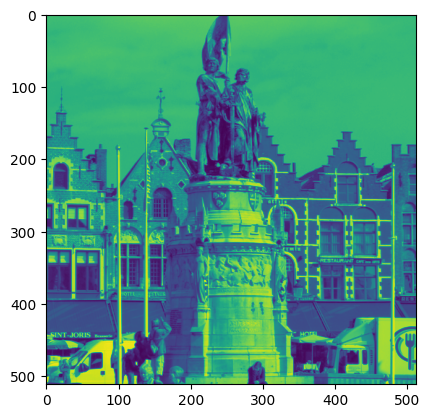

In [5]:
plt.imshow(image)

In [6]:
image

array([[178, 179, 180, ..., 170, 170, 169],
       [178, 179, 180, ..., 169, 169, 169],
       [177, 179, 179, ..., 169, 169, 170],
       ...,
       [230, 220, 179, ..., 163, 162, 160],
       [230, 170,  73, ..., 160, 159, 163],
       [184, 116,  46, ..., 161, 162, 161]], dtype=uint8)

In [7]:
image.shape

(512, 512)

In [8]:
def get_pseudorandom_coord_list(image_shape, seed=None):
    x_shape, y_shape = image_shape
    coordinate_pairs = np.stack(np.meshgrid(np.arange(x_shape), np.arange(y_shape)), axis=-1).reshape(-1, 2)
    if seed:
        np.random.seed(seed)
    return np.random.permutation(coordinate_pairs)

In [9]:
get_pseudorandom_coord_list(image.shape)

array([[ 63, 315],
       [448, 498],
       [217, 273],
       ...,
       [121, 284],
       [292,  40],
       [134, 495]])

In [10]:
def get_binary_plane(image, plane_number):
    # plane number is indexing from 1
    
    return np.bitwise_and(image, 1 << (plane_number - 1)).astype(np.uint8)

<AxesSubplot:>

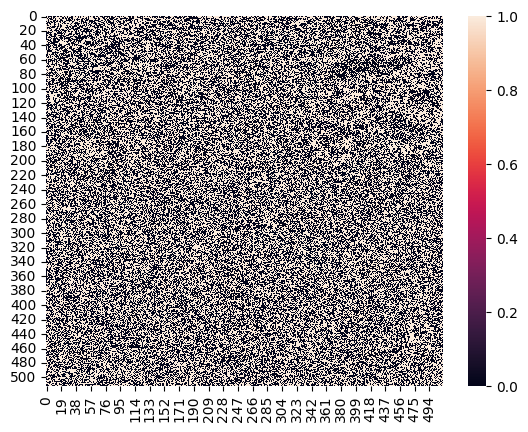

In [11]:
sns.heatmap(get_binary_plane(image, 1))

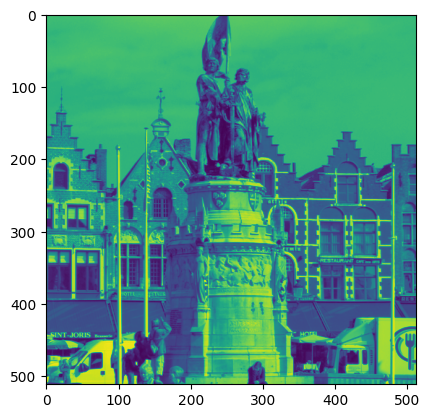

In [12]:
plt.imshow(np.sum(np.stack([get_binary_plane(image, i) for i in range(1, 8 + 1)], axis=-1), axis=-1))

In [13]:
def generate_payload(N1, N2, q):
    Nb = int(N1 * N2 * q)
    return np.random.randint(0, 1 + 1, size=(Nb,), dtype=np.uint8)

In [14]:
def lsb_replacement(image_, bit_num, position_pairs, payload):
    image = image_.copy()
    for i, payload_bit in enumerate(payload):
        x, y = position_pairs[i]
        
        # example: let bit_num = 3
        # np.binary_repr(1 << (bit_num - 1))         = '00000100'
        # np.binary_repr(255)                        = '11111111'
        # np.binary_repr(255 ^ (1 << (bit_num - 1))) = '11111011'
        image[x, y] &= (255 ^ (1 << (bit_num - 1)))  # copy all except bit_num'th bit, bit_num'th bit equals 0
        image[x, y] += payload_bit << (bit_num - 1)  # adding '00000*00' where * is payload_bit
    return image

In [15]:
x_shape, y_shape = image.shape

coordinate_pairs = np.stack(np.meshgrid(np.arange(x_shape), np.arange(y_shape)), axis=-1).reshape(-1, 2)
coordinate_pairs_mean = coordinate_pairs.mean(axis=0).astype(int)

circle = np.array(list(filter(lambda x: x[0]**2 + x[1]**2 < 10000, coordinate_pairs - coordinate_pairs_mean))) + coordinate_pairs_mean

In [18]:
noised_image = lsb_replacement(image, 1, circle, np.ones(shape=(20000,), dtype=int))

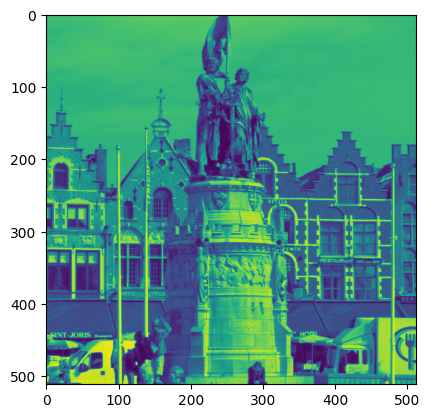

In [19]:
plt.imshow(noised_image)

<AxesSubplot:>

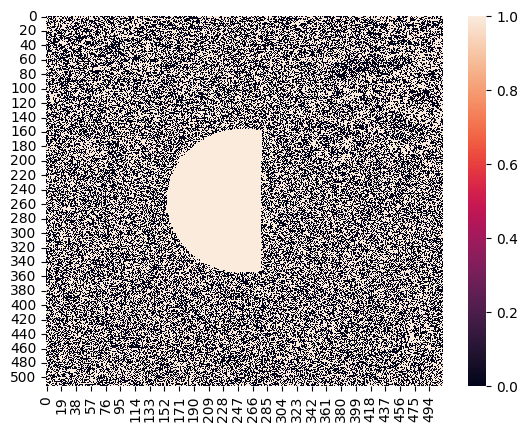

In [20]:
sns.heatmap(get_binary_plane(noised_image, 1))

In [21]:
noised_image = lsb_replacement(image, 1, get_pseudorandom_coord_list(image.shape), generate_payload(*image.shape, q=0.8))

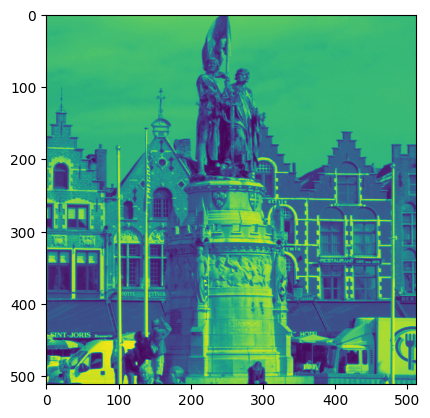

In [22]:
plt.imshow(noised_image)

<AxesSubplot:>

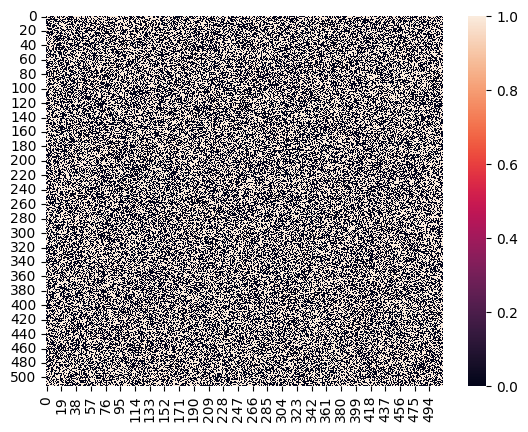

In [23]:
sns.heatmap(get_binary_plane(noised_image, 1))

In [24]:
hist_e = np.histogram(image, bins=256, range=(0, 256))[0]

In [25]:
hist_e

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           6,    28,    71,   143,   198,   187,   308,   434,   449,
         480,   526,   459,   405,   444,   430,   433,   494,   503,
         644,   594,   702,   725,   667,   634,   662,   670,   644,
         626,   661,   693,   740,   762,   772,   853,   832,   826,
         872,   801,   864,   811,   793,   876,   879,   864,   891,
         914,   916,   986,  1040,  1037,  1112,  1115,  1100,  1172,
        1227,  1454,  1616,  1863,  2396,  2487,  1904,  1628,  1569,
        1515,  1460,  1311,  1350,  1360,  1474,  1569,  1649,  1775,
        1844,  1895,  1792,  1816,  1632,  1545,  1363,  1173,  1001,
         881,   831,   776,   834,   750,   752,   739,   748,   734,
         699,   749,   703,   691,   761,   716,   683,   699,   678,
         703,   685,   662,   722,   734,   695,   736,   733,   715,
         720,   770,   749,   818,   799,   842,   859,   909,   874,
         871,   885,

In [26]:
def get_hist_t(hist_e):
    assert len(hist_e) % 2 == 0
    return np.array([(hist_e[2 * (i // 2)] + hist_e[2 * (i // 2) + 1]) / 2 for i in range(len(hist_e))])

In [27]:
hist_t = get_hist_t(hist_e)

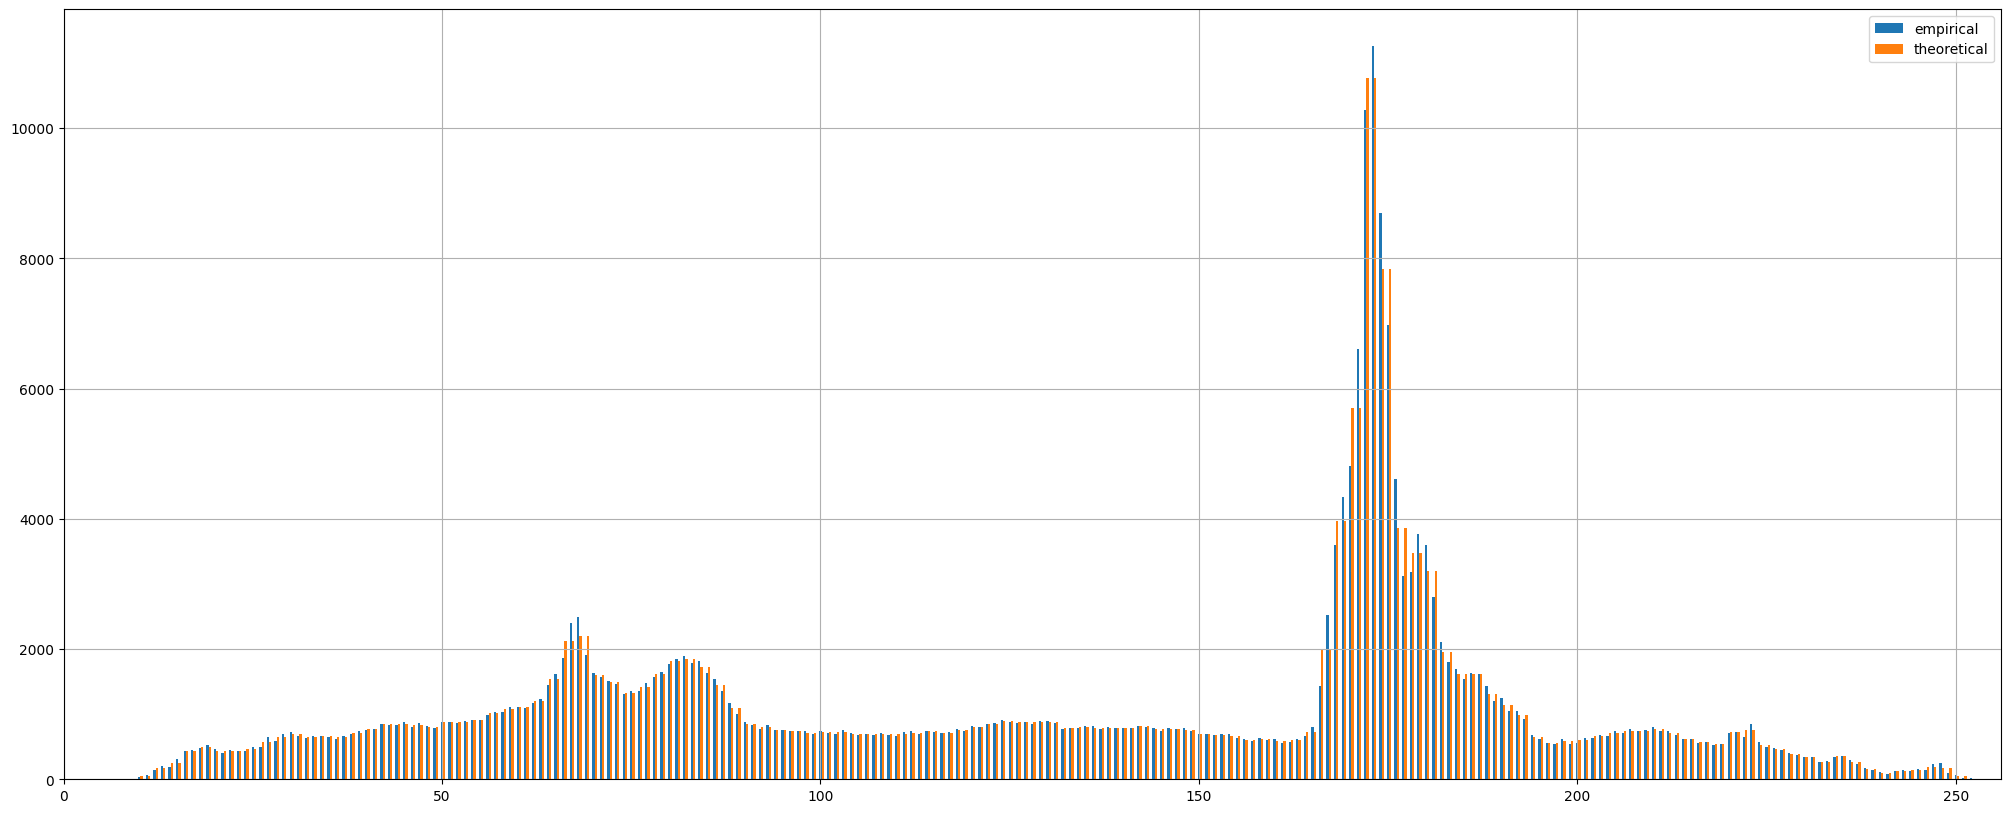

In [28]:
plt.figure(figsize=(25, 10))
plt.bar(range(len(hist_e)), hist_e, width=0.3, label='empirical')
plt.bar(np.arange(len(hist_t))+0.3, hist_t, width=0.3, label='theoretical')
plt.legend()
plt.xlim((0, 256))
plt.grid()

In [29]:
def get_chi_components(hist_e, hist_t):
    diffs_chi = (hist_e - hist_t) ** 2
    non_zero_mask = hist_t > 0
    diffs_chi[non_zero_mask] /= hist_t[non_zero_mask]
    return diffs_chi

In [30]:
diffs_chi = get_chi_components(hist_e, hist_t)

In [31]:
hist_e1 = np.histogram(noised_image, bins=256, range=(0, 256))[0]

In [32]:
hist_t1 = get_hist_t(hist_e1)

In [33]:
diffs_chi1 = get_chi_components(hist_e1, hist_t1)

In [34]:
diffs_chi.sum(), diffs_chi1.sum()

(1946.8769383309937, 185.21321496019087)

In [35]:
diffs_chi.max(), diffs_chi1.max()

(147.96814964610718, 10.246054333764553)

In [36]:
np.median(diffs_chi), np.median(diffs_chi1)

(0.7284211497807636, 0.27220900815338134)

In [37]:
diffs_chi.mean(), diffs_chi1.mean()

(7.604988040355444, 0.7234891209382456)

In [38]:
diffs_chi.min(), diffs_chi1.min()

(0.0, 0.0)